In [1]:
import numpy as np
import scipy
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import backend as K
from keras import Model
from keras.src.optimizers import Adam
from matplotlib import pyplot as plt

from utils.training.data_loading import load_spectro
from utils.training.keras_models import time_segmenter_model

2023-12-12 18:04:35.544854: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 18:04:35.737553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 18:04:35.737608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 18:04:35.738815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 18:04:35.873054: I tensorflow/core/platform/cpu_feature_g

In [2]:
CHECKPOINT = "/media/plerolland/LaBoite/PublicData/trainings/checkpoints_auc_acc/checkpoints_seg/all/cp-0023.ckpt"
SIZE = (128, 186)

model = time_segmenter_model(SIZE)
model.load_weights(CHECKPOINT)
model.summary()

2023-12-12 18:04:39.370052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 18:04:39.471747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 18:04:39.471934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "time_segmenter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 186, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 186, 1)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 186, 16)      1040      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 186, 16)      16400     
                                                                 
 block1_conv3 (Conv2D)       (None, 128, 186, 16)      16400     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 186, 16)       0         
 D)                                                              
                                                    

In [3]:
conv_layers = []
for layer in model.layers:
    if 'conv' not in layer.name: # maxpooling, flattening
        continue
    filters, biases = layer.get_weights()
    conv_layers.append(layer)
    print(layer.name, filters.shape)

block1_conv1 (8, 8, 1, 16)
block1_conv2 (8, 8, 16, 16)
block1_conv3 (8, 8, 16, 16)
block2_conv1 (5, 8, 16, 32)
block2_conv2 (5, 8, 32, 32)
block2_conv3 (5, 8, 32, 32)
block3_conv1 (3, 8, 32, 64)
block3_conv2 (3, 8, 64, 64)
block3_conv3 (3, 8, 64, 64)
block4_conv1 (2, 8, 64, 128)
block4_conv2 (2, 8, 128, 128)
block4_conv3 (2, 8, 128, 128)
output_conv (1, 1, 128, 1)


## Filters visualization

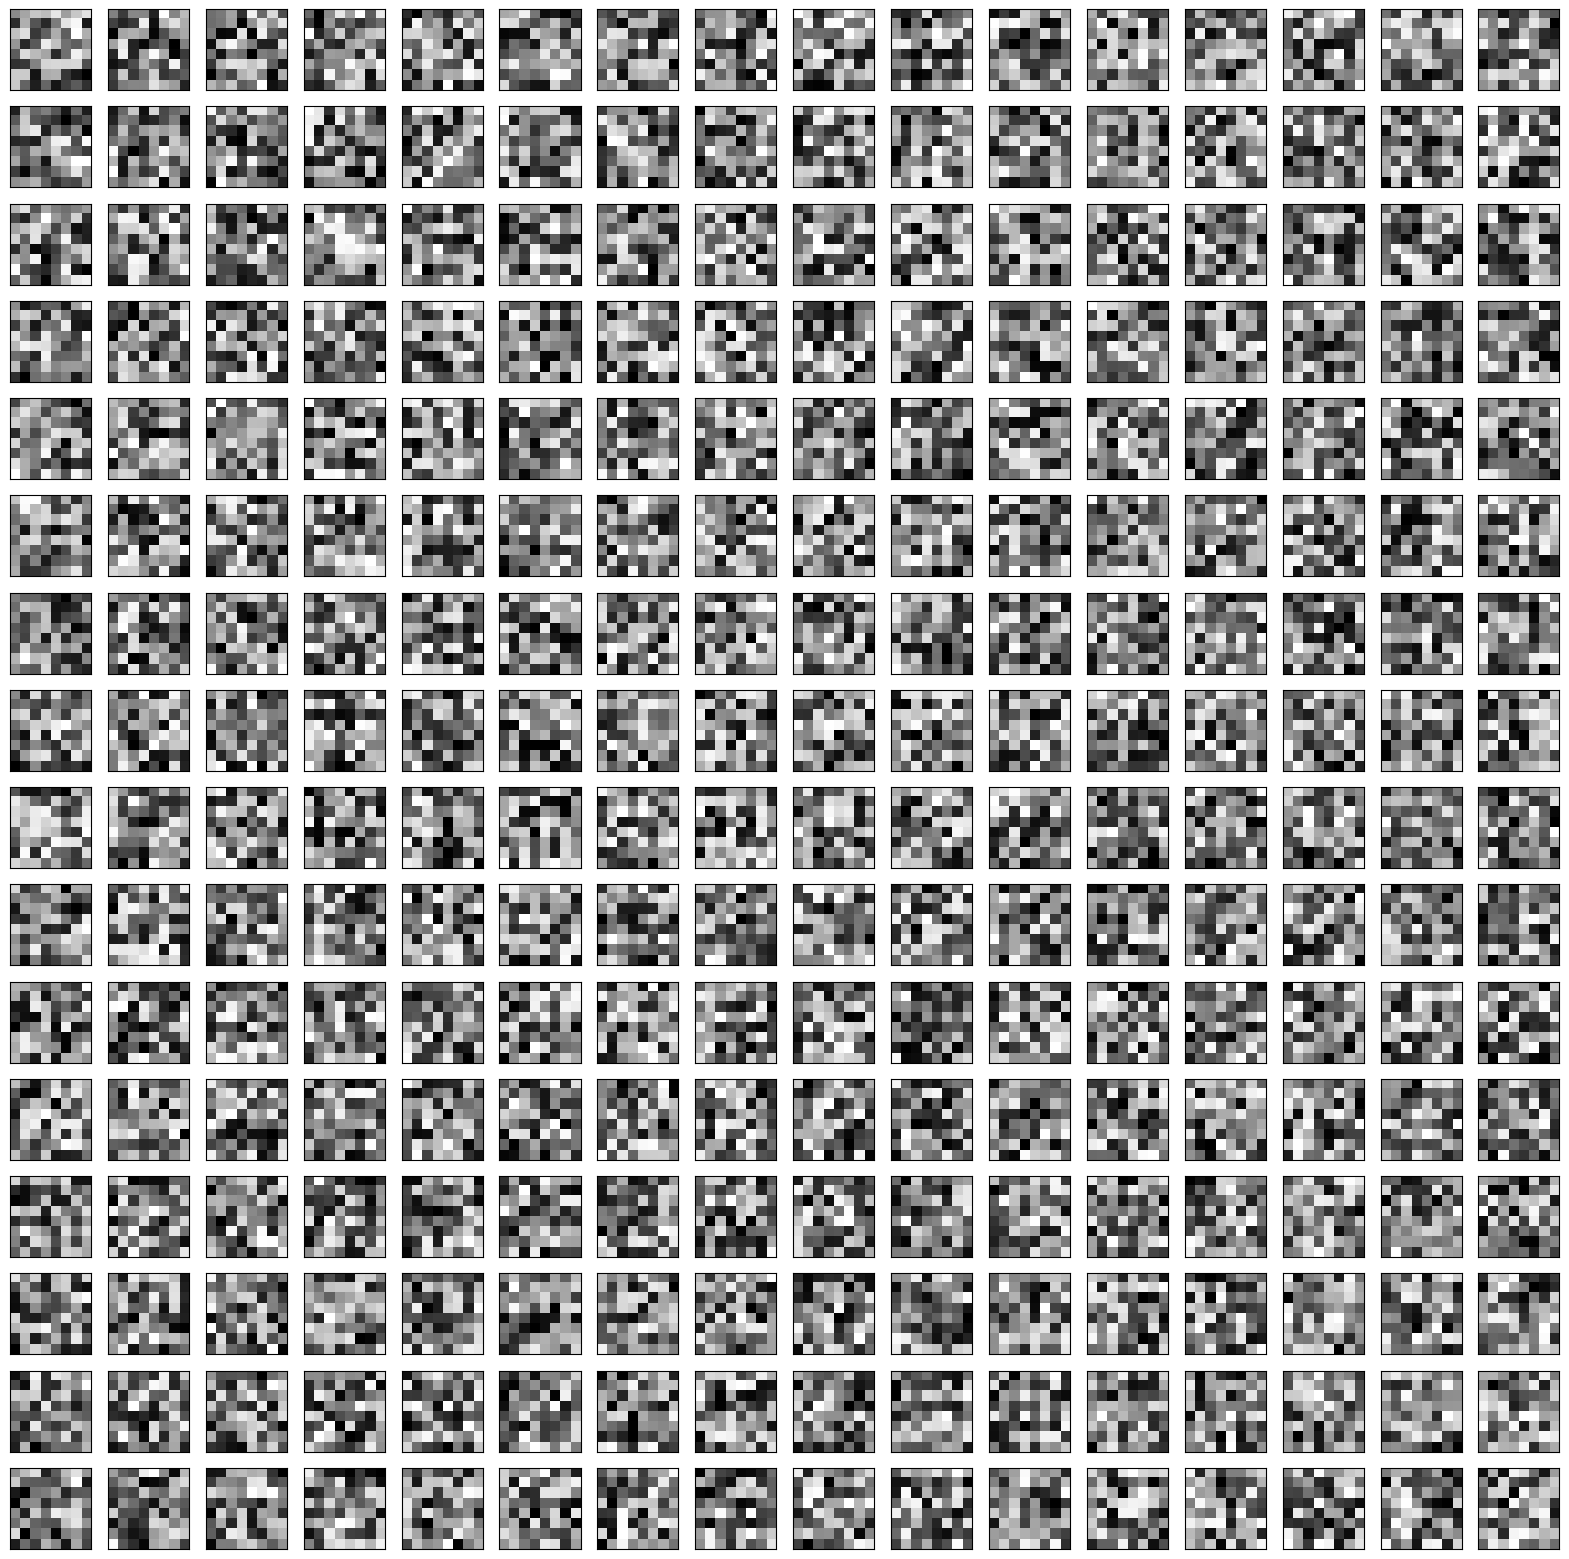

In [4]:
filters, biases = conv_layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)  # normalization of filters

# plot first few filters
n_filters, n_channels = 16, 16
plot_idx = 1
plt.subplots(n_filters, n_channels, figsize=(20,20))
for i in range(n_filters):
    f = filters[:, :, :, i]
    # plot some channels
    for j in range(n_channels):
         ax = plt.subplot(n_filters, n_channels, plot_idx)
         ax.set_xticks([])
         ax.set_yticks([])
         plt.imshow(f[:, :, j], cmap='gray')
         plot_idx += 1
# show the figure
plt.show()

## Filters outputs visualization

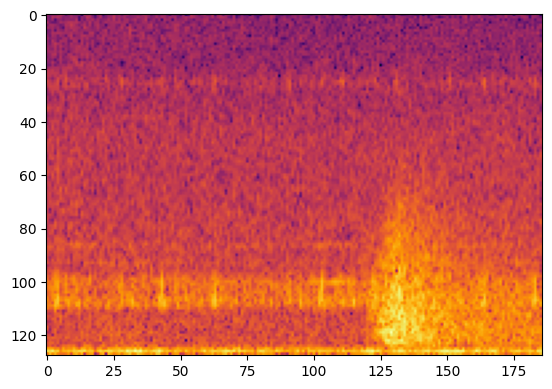

In [5]:
img_path = "/media/plerolland/LaBoite/PublicData/training/spectrograms/positives/NEAMS/20180712_163451.png"
img = load_spectro(img_path, SIZE, 1)
plt.imshow(img, cmap="inferno")

1/1 [==============================] - 0s 34ms/step


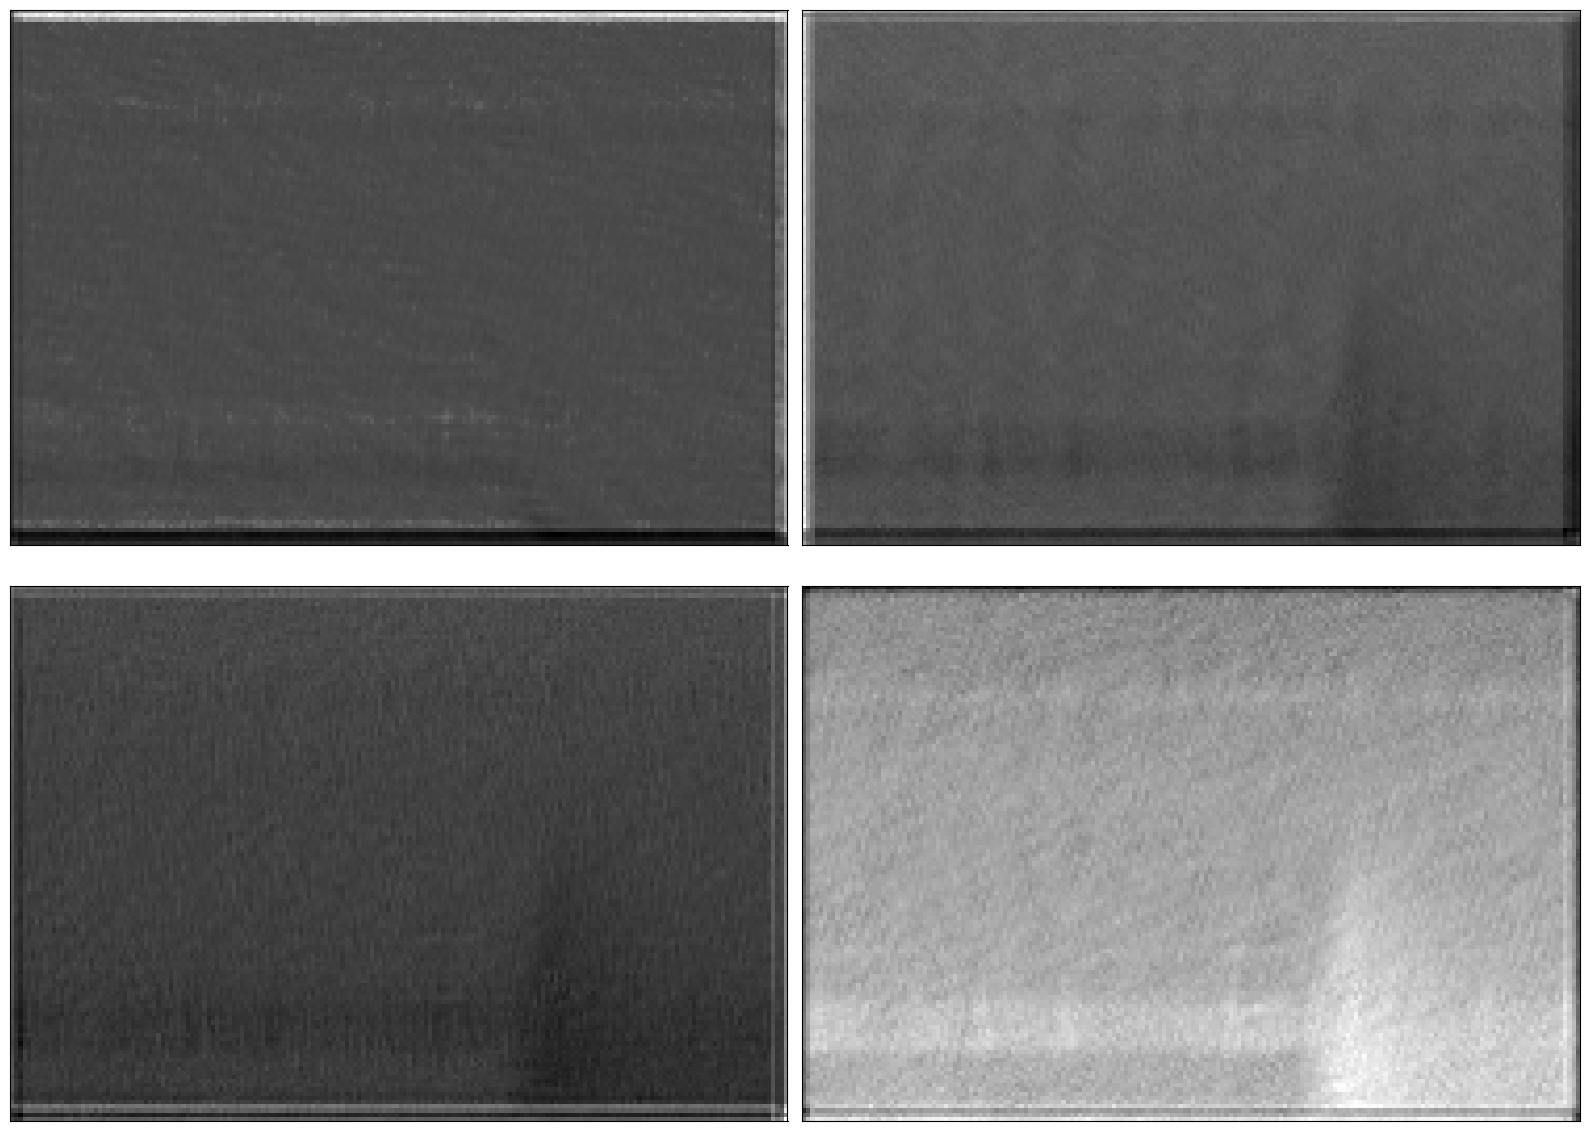

In [31]:
block_id = 0
conv_id = 0
square = 2

temp_model = Model(inputs=model.inputs, outputs=conv_layers[3*block_id+conv_id].output)
feature_maps = temp_model.predict((img.numpy()).reshape(1, SIZE[0], SIZE[1], 1))

plot_idx = 1
aspect = 2**(min(block_id,1))*4**(max(block_id-1,0))
plt.subplots(square, square, figsize=(16,12))
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, plot_idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, plot_idx-1], cmap='gray', aspect=aspect)
        plot_idx += 1
plt.tight_layout()
plt.savefig("../../../figures/conv1_features.png", dpi=150, bbox_inches='tight')

# Heatmaps

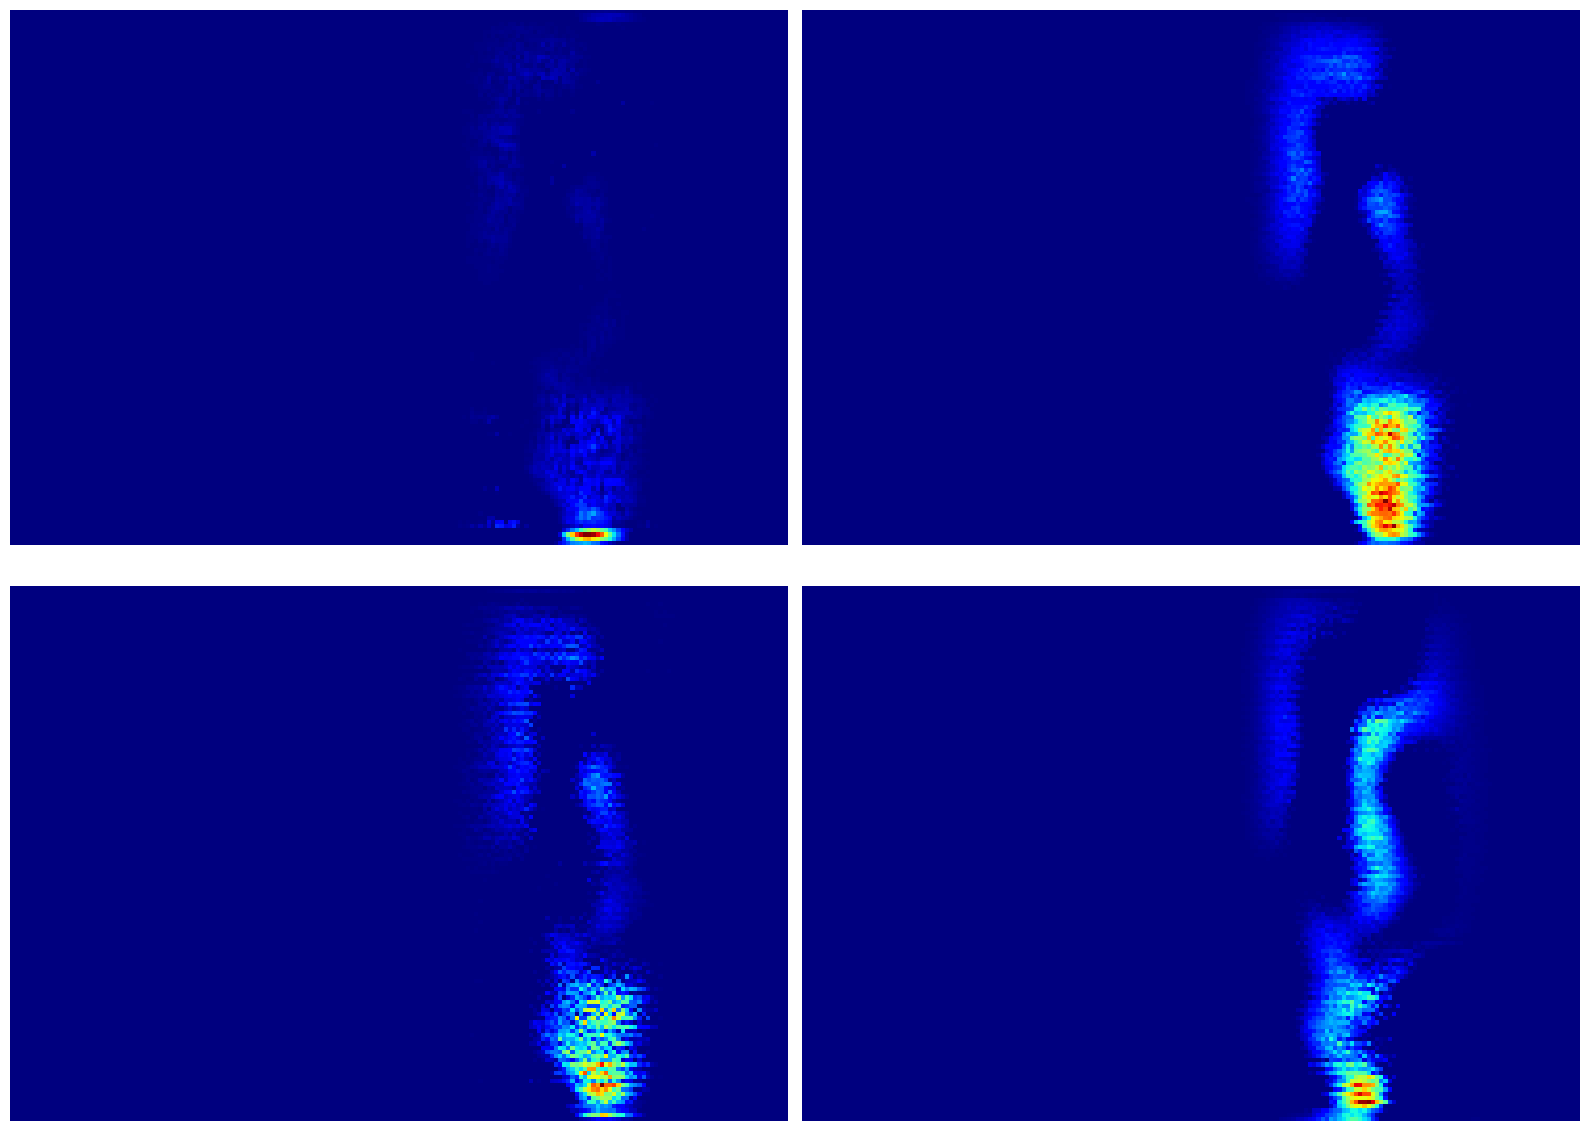

In [32]:
heatmap_model = Model(inputs=model.inputs, outputs=[conv_layers[3*block_id+conv_id].output, model.output])

with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model((img.numpy()).reshape(1, SIZE[0], SIZE[1], 1))
    loss = K.mean(predictions[0, np.argmax(predictions[0])]) # predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)

plt.subplots(square, square, figsize=(16,12))
plot_idx=0
for _ in range(square):
    for _ in range(square):
        plt.subplot(square, square, plot_idx+1)
        
        co = conv_output[:,:,:,plot_idx]
        heatmap = np.multiply(np.array(grads)[:,:,:,plot_idx], co)
        heatmap = np.array(heatmap)
        heatmap = np.maximum(heatmap, 0)
        max_heat = np.max(heatmap)
        heatmap /= max_heat
    
        plt.imshow(heatmap.reshape((SIZE[0],SIZE[1],1)), cmap='jet')
        plt.axis('off')
        plot_idx += 1
plt.tight_layout()
plt.savefig("../../../figures/conv1_heatmaps.png", dpi=150, bbox_inches='tight')

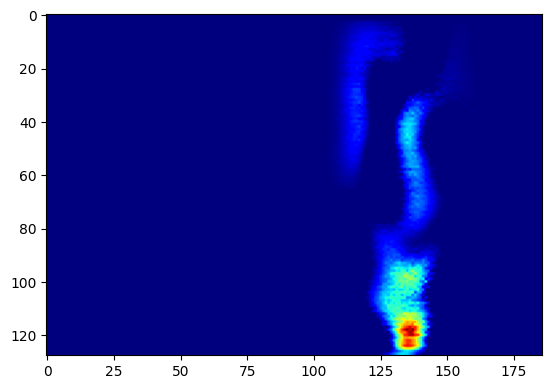

In [8]:
t = []
for i in range(16):
    
    co = conv_output[:,:,:,i]
    heatmap = np.multiply(np.array(grads)[:,:,:,i], co)
    heatmap = np.array(heatmap)
    t.append(heatmap)

heatmap = np.maximum(np.sum(t, axis=0), 0)
    
plt.imshow(heatmap.reshape((SIZE[0],SIZE[1],1)), cmap='jet')

## Output fitting
Starting from an image and an objective output, tune the image to minimize the loss of the model

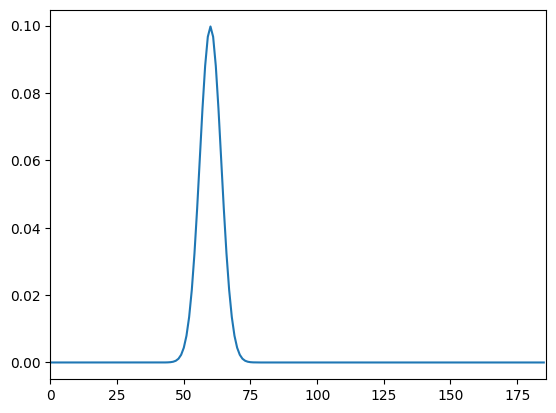

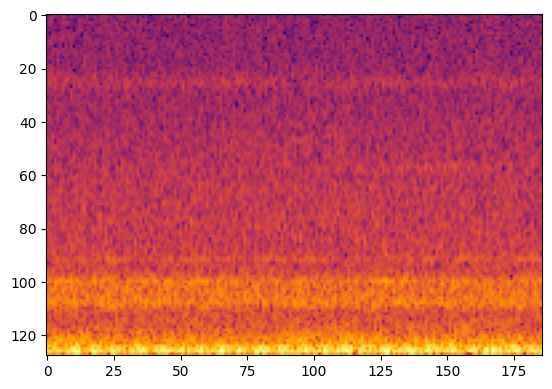

In [8]:
# we define a gaussian that the model will try to match
mean = 60
var = 4
law = scipy.stats.norm(mean, var)
expected_output = [law.pdf(i) for i in range(SIZE[1])]

# plot it
plt.plot(expected_output)
plt.xlim(0, SIZE[1])
plt.show()

# now choose an input image from which the optimization process will start
start_img_path = "/media/plerolland/LaBoite/PublicData/training/spectrograms/negatives/SSWIR/20180405_174654.png"
start_img = load_spectro(start_img_path, SIZE, 1)

# show it
plt.imshow(start_img, cmap="inferno")
plt.show()

In [92]:
# assign the image as a tf variable to optimize
input_to_optimize = tf.Variable(np.copy(start_img).reshape((1, SIZE[0], SIZE[1], 1)))

# define the loss function
@tf.function
def loss():
    output = model(input_to_optimize, training=False)
    return tf.keras.losses.mean_squared_error(expected_output, output)

optimizer = Adam(learning_rate=0.1)
num_iterations = 10000

# optimization loop
for i in (pbar:=tqdm(range(num_iterations))):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(input_to_optimize)
        output = model(input_to_optimize, training=False)
        
        # compute loss and gradient
        l = tf.keras.losses.mean_squared_error(expected_output, output)
        g = tape.gradient(l, input_to_optimize)
        
        # apply optimization
        optimizer.apply_gradients(zip([g], [input_to_optimize]))
        
        # show the loss in the progress bar
        pbar.set_postfix_str(str(l))

print("Final loss:", loss().numpy())

 25%|██▌       | 2520/10000 [01:07<03:19, 37.57it/s, tf.Tensor([1.176095e-06], shape=(1,), dtype=float32)] 
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f92193325f0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: 

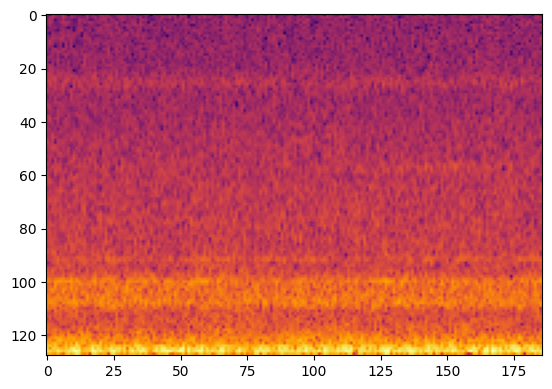

1/1 [==============================] - 0s 6ms/step


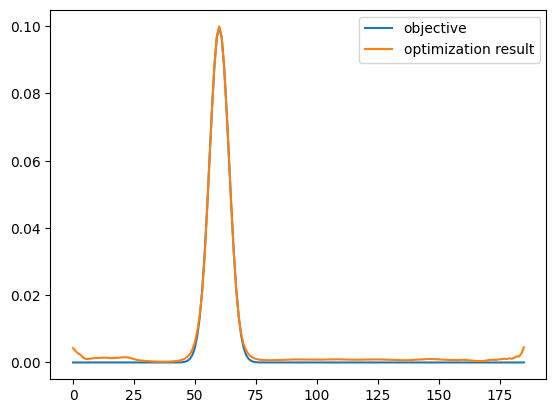

In [100]:
new_img = input_to_optimize.numpy().reshape((128,186,1))
plt.imshow(new_img, cmap="inferno")
plt.show()
plt.plot(expected_output, label="objective")
plt.plot(model.predict(input_to_optimize).reshape(SIZE[1]), label="optimization result")
plt.legend(loc="upper right")
plt.show()